In [1]:
# !conda install -c conda-forge folium=0.10.0 geopy=1.20.0 --yes
from botocore.client import Config
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import folium
import ibm_boto3
import json
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import types

In [2]:
# The code was removed by Watson Studio for sharing.

Retrieving Mexico City's colonies data as a dataframe

In [3]:
def __iter__(self): return 0

body = client_c00e74e766a148bf886ec060f0b9c13a.get_object(Bucket='fashionproject-donotdelete-pr-mv2ccdtjv6sbh4',Key='colonias_cdmx_2019.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

cdmx_raw_df = pd.read_csv(body, sep=";")

In Mexico, neighborhoods are known as "colonies"

In [4]:
print("cdmx_raw_df.dtypes:")
print(cdmx_raw_df.dtypes)

print("cdmx_raw_df.shape:", cdmx_raw_df.shape)

cdmx_raw_df.head()

cdmx_raw_df.dtypes:
COLONIA       object
ENTIDAD      float64
Geo Point     object
Geo Shape     object
CVE_ALC        int64
ALCALDIA      object
CVE_COL       object
SECC_COM      object
SECC_PAR      object
dtype: object
cdmx_raw_df.shape: (1812, 9)


,COLONIA,ENTIDAD,Geo Point,Geo Shape,CVE_ALC,ALCALDIA,CVE_COL,SECC_COM,SECC_PAR
0,LOMAS DE REFORMA,9.0,"19.4016815485,-99.2354719599","{""type"": ""Polygon"", ""coordinates"": [[[-99.2359...",16,MIGUEL HIDALGO,16-043,"4971, 4983",NaN
1,DANIEL GARZA (AMPL),9.0,"19.4092184712,-99.1938392453","{""type"": ""Polygon"", ""coordinates"": [[[-99.1932...",16,MIGUEL HIDALGO,16-025,"4951, 4952, 4953","4957, 4959, 4960, 4973, 4990"
2,IGNACIO MANUEL ALTAMIRANO,9.0,"19.4631440514,-99.1968280035","{""type"": ""Polygon"", ""coordinates"": [[[-99.1966...",16,MIGUEL HIDALGO,16-034,NaN,5110
3,LEGARIA,9.0,"19.4555305454,-99.1930482732","{""type"": ""Polygon"", ""coordinates"": [[[-99.1905...",16,MIGUEL HIDALGO,16-036,5046,"5038, 5045, 5058"
4,LEGARIA (U HAB),9.0,"19.450020036,-99.2010760751","{""type"": ""Polygon"", ""coordinates"": [[[-99.2024...",16,MIGUEL HIDALGO,16-037,NaN,"5069, 5070"


Displaying summary statistics for cdmx_raw_df

In [5]:
cdmx_raw_df.describe(include="all")

,COLONIA,ENTIDAD,Geo Point,Geo Shape,CVE_ALC,ALCALDIA,CVE_COL,SECC_COM,SECC_PAR
count,1812,1810.0,1808,1808,1812.000000,1812,1812,1132,1543
unique,1743,NaN,1808,1808,NaN,16,1812,1132,1358
top,MIGUEL HIDALGO,NaN,"19.3234027183,-99.1654676133","{""type"": ""Polygon"", ""coordinates"": [[[-99.1185...",NaN,IZTAPALAPA,12-131,"3403, 3404, 3405, 3406",3491
freq,4,NaN,1,1,NaN,293,1,1,9
mean,NaN,9.0,NaN,NaN,8.748896,NaN,NaN,NaN,NaN
std,NaN,0.0,NaN,NaN,4.332199,NaN,NaN,NaN,NaN
min,NaN,9.0,NaN,NaN,2.000000,NaN,NaN,NaN,NaN
25%,NaN,9.0,NaN,NaN,5.000000,NaN,NaN,NaN,NaN
50%,NaN,9.0,NaN,NaN,8.000000,NaN,NaN,NaN,NaN
75%,NaN,9.0,NaN,NaN,12.000000,NaN,NaN,NaN,NaN


Counting missing data per column of interest

In [6]:
cdmx_missing_data_df = cdmx_raw_df.isna()

print("COLONIA:")
print(cdmx_missing_data_df["COLONIA"].value_counts())

print("Geo Point")
print(cdmx_missing_data_df["Geo Point"].value_counts())

print("ALCALDIA:")
print(cdmx_missing_data_df["ALCALDIA"].value_counts())

COLONIA:
False    1812
Name: COLONIA, dtype: int64
Geo Point
False    1808
True        4
Name: Geo Point, dtype: int64
ALCALDIA:
False    1812
Name: ALCALDIA, dtype: int64


Showing the rows with missing data

In [7]:
cdmx_raw_df[cdmx_missing_data_df["Geo Point"]]

,COLONIA,ENTIDAD,Geo Point,Geo Shape,CVE_ALC,ALCALDIA,CVE_COL,SECC_COM,SECC_PAR
1037,MAZA,9.0,NaN,NaN,15,CUAUHTEMOC,15-018,4666,"4667, 4716"
1502,SAN PABLO OZTOTEPEC (PBLO),9.0,NaN,NaN,9,MILPA ALTA,09-008,"3153, 3154, 3155, 3156, 3157, 3158",NaN
1619,LOS CERRILLOS I,9.0,NaN,NaN,13,XOCHIMILCO,13-025,NaN,"4160, 4165, 4166"
1638,CHIMALCOYOC,9.0,NaN,NaN,12,TLALPAN,12-020,NaN,"3911, 4087, 4088, 4091"


Cleaning and shaping cdmx_raw_df

In [8]:
# Removing columns of no interest
cdmx_clean_df = cdmx_raw_df.drop(["ENTIDAD", "Geo Shape", "CVE_ALC", "CVE_COL", "SECC_COM", "SECC_PAR"], axis=1)

# Creating a dictionary of translations from spanish to english for the column labels
colonies_column_labels_translations_es_en_dict = {
    "COLONIA": "Colony",
    "ALCALDIA": "Borough"
}

# Translating columns
cdmx_clean_df = cdmx_clean_df.rename(columns=colonies_column_labels_translations_es_en_dict)

# Spliting the Geo Point string to get the Latitude and Longitude strings
cdmx_clean_df["Colony Latitude"], cdmx_clean_df["Colony Longitude"] = cdmx_clean_df["Geo Point"].str.split(",").str

# Casting Latitude and Longitude as floats
cdmx_clean_df[["Colony Latitude", "Colony Longitude"]] = cdmx_clean_df[["Colony Latitude", "Colony Longitude"]].astype("float")

# Removing the Geo Point column
cdmx_clean_df = cdmx_clean_df.drop("Geo Point", axis=1)

# Rearranging the columns order
cdmx_clean_df = cdmx_clean_df.reindex(columns=["Borough", "Colony", "Colony Latitude", "Colony Longitude"])

# Since there are just 4 rows with a missing geo point, it is possible to retrieve them manually by using Google maps
cdmx_clean_df.iloc[1037, [2, 3]] = [19.4552146, -99.1288375]

cdmx_clean_df.iloc[1502, [2, 3]] = [19.182184, -99.081325]

cdmx_clean_df.iloc[1619, [2, 3]] = [19.2471687, -99.0214895]

cdmx_clean_df.iloc[1638, [2, 3]] = [19.273632, -99.1694116]

print("cdmx_clean_df.dtypes:")
print(cdmx_clean_df.dtypes)

print("cdmx_clean_df.shape:", cdmx_clean_df.shape)

cdmx_clean_df.head()

cdmx_clean_df.dtypes:
Borough              object
Colony               object
Colony Latitude     float64
Colony Longitude    float64
dtype: object
cdmx_clean_df.shape: (1812, 4)


,Borough,Colony,Colony Latitude,Colony Longitude
0,MIGUEL HIDALGO,LOMAS DE REFORMA,19.401682,-99.235472
1,MIGUEL HIDALGO,DANIEL GARZA (AMPL),19.409218,-99.193839
2,MIGUEL HIDALGO,IGNACIO MANUEL ALTAMIRANO,19.463144,-99.196828
3,MIGUEL HIDALGO,LEGARIA,19.455531,-99.193048
4,MIGUEL HIDALGO,LEGARIA (U HAB),19.450020,-99.201076


Counting the number of colonies per borough

In [9]:
print(cdmx_clean_df[["Borough", "Colony"]].groupby(["Borough"]).count())

                        Colony
Borough                       
ALVARO OBREGON             249
AZCAPOTZALCO               111
BENITO JUAREZ               64
COYOACAN                   153
CUAJIMALPA DE MORELOS       43
CUAUHTEMOC                  64
GUSTAVO A. MADERO          232
IZTACALCO                   55
IZTAPALAPA                 293
LA MAGDALENA CONTRERAS      52
MIGUEL HIDALGO              88
MILPA ALTA                  12
TLAHUAC                     58
TLALPAN                    178
VENUSTIANO CARRANZA         80
XOCHIMILCO                  80


Retrieving Cuauhtemoc's colonies

In [10]:
cuauhtemoc_colonies_df = cdmx_clean_df[cdmx_clean_df["Borough"] == "CUAUHTEMOC"].reset_index(drop=True)

print("cuauhtemoc_colonies_df.shape:")
print(cuauhtemoc_colonies_df.shape)

cuauhtemoc_colonies_df.head()

cuauhtemoc_colonies_df.shape:
(64, 4)


,Borough,Colony,Colony Latitude,Colony Longitude
0,CUAUHTEMOC,GUERRERO IV,19.440422,-99.142214
1,CUAUHTEMOC,NONOALCO-TLATELOLCO (U HAB) III,19.451696,-99.135357
2,CUAUHTEMOC,DOCTORES II,19.419874,-99.150850
3,CUAUHTEMOC,DOCTORES V,19.410377,-99.146790
4,CUAUHTEMOC,SAN SIMON TOLNAHUAC,19.459532,-99.143180


Defining Mexico City's location

In [11]:
cdmx_address = "Mexico City, CDMX"

cdmx_geolocator = Nominatim(user_agent="cdmx_explorer")

cdmx_location = cdmx_geolocator.geocode(cdmx_address)
print("cdmx_location:", cdmx_location)

cdmx_latitude = cdmx_location.latitude
print("cdmx_latitude:", cdmx_latitude)

cdmx_longitude = cdmx_location.longitude
print("cdmx_longitude:", cdmx_longitude)

cdmx_location: Ciudad de México, Cuauhtémoc, CDMX, 06060, México
cdmx_latitude: 19.4326009
cdmx_longitude: -99.1333416


Creating a map of Mexico City, showing the Cuauhtemoc's colonies

In [12]:
cdmx_map = folium.Map(location=[cdmx_latitude, cdmx_longitude], zoom_start=14)

for n_borough, n_colony, n_latitude, n_longitude in zip(cuauhtemoc_colonies_df["Borough"], cuauhtemoc_colonies_df["Colony"], cuauhtemoc_colonies_df["Colony Latitude"], cuauhtemoc_colonies_df["Colony Longitude"]):
    n_label = folium.Popup("{}, {}".format(n_borough, n_colony), parse_html=True)
    folium.CircleMarker(
        [n_latitude, n_longitude],
        radius=5,
        popup=n_label,
        color="blue",
        fill=True,
        fill_color="#3186cc",
        fill_opacity=0.7,
        parse_html=True
    ).add_to(cdmx_map)

cdmx_map

![alt text](https://raw.githubusercontent.com/iSaaC92G/Crime-Analysis-of-Mexico-City/master/images/outputs/cuauhtemoc_colonies.jpg "Cuauhtemoc Colonies")

Defining Foursquare credentials (CLIENT_ID, CLIENT_SECRET, VERSION). Hiding sensitive data

In [13]:
# The code was removed by Watson Studio for sharing.

Testing the Foursquare Get Venue Recommendations endpoint with the first row of the Cuauhtemoc's DataFrame

In [14]:
GET_VENUE_RECOMMENDATIONS_URL = "https://api.foursquare.com/v2/venues/explore"

def get_foursquare_endpoint_params(client_id, client_secret, version, latitude, longitude, radius=200, limit=10):
    """
    This function returns a dictionary with some of the parameters used by the Foursquare Get Venue Recommendations endpoint.
    """
    return dict(
        client_id=client_id,
        client_secret=client_secret,
        v=version,
        ll="{},{}".format(latitude, longitude),
        radius=radius,
        limit=limit
    )

# Using the location of the first colony in the cuauhtemoc_colonies_df DataFrame
params = get_foursquare_endpoint_params(CLIENT_ID, CLIENT_SECRET, VERSION, cuauhtemoc_colonies_df.loc[0, "Colony Latitude"], cuauhtemoc_colonies_df.loc[0, "Colony Longitude"])

# Making the request to the endpoint
response = requests.get(url=GET_VENUE_RECOMMENDATIONS_URL, params=params)

# Retrieving the response in JSON format
data = json.loads(response.text)

Analyzing the response data

In [15]:
print("data:")
print(data)

# So, the following path leads to the venues information
data["response"]["groups"][0]["items"][0]

data:
{'meta': {'code': 200, 'requestId': '5d984f9a492822002e82ccec'}, 'response': {'headerLocation': 'Guerrero', 'headerFullLocation': 'Guerrero, Mexico City', 'headerLocationGranularity': 'neighborhood', 'totalResults': 4, 'suggestedBounds': {'ne': {'lat': 19.442221897000003, 'lng': -99.14030880947615}, 'sw': {'lat': 19.438621893399997, 'lng': -99.14411933692384}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '559d4fea498e2b027d4099f4', 'name': 'Palacio De Bellas Artes', 'location': {'lat': 19.4405647553228, 'lng': -99.143499231848, 'labeledLatLngs': [{'label': 'display', 'lat': 19.4405647553228, 'lng': -99.143499231848}], 'distance': 135, 'cc': 'MX', 'city': 'Ciudad de México', 'state': 'Distrito Federal', 'country': 'México', 'formattedAddress': ['Ciudad de México, Distrito Federal', 'México']}, 'categori

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '559d4fea498e2b027d4099f4',
  'name': 'Palacio De Bellas Artes',
  'location': {'lat': 19.4405647553228,
   'lng': -99.143499231848,
   'labeledLatLngs': [{'label': 'display',
     'lat': 19.4405647553228,
     'lng': -99.143499231848}],
   'distance': 135,
   'cc': 'MX',
   'city': 'Ciudad de México',
   'state': 'Distrito Federal',
   'country': 'México',
   'formattedAddress': ['Ciudad de México, Distrito Federal', 'México']},
  'categories': [{'id': '4bf58dd8d48988d1e2931735',
    'name': 'Art Gallery',
    'pluralName': 'Art Galleries',
    'shortName': 'Art Gallery',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/artgallery_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referralId': 'e-0-559d4fea498e2b027d4099f4-0'}

Defining a function to retrieve recommended venues around given locations

In [16]:
def get_recommended_nearby_venues(names, latitudes, longitudes, radius=200, limit=10):
    """
    This function returns a DataFrame of venues by iterating over 3 lists: names, latitudes, longitudes (they must be of
    the same size!) and by making a request to the Foursquare Get Venue Recommendations endpoint for each location.
    """
    venues_list = []
    for n_name, n_latitude, n_longitude in zip(names, latitudes, longitudes):
        n_params = get_foursquare_endpoint_params(CLIENT_ID, CLIENT_SECRET, VERSION, n_latitude, n_longitude, radius, limit)
        n_response = requests.get(url=GET_VENUE_RECOMMENDATIONS_URL, params=n_params)
        n_data = json.loads(n_response.text)
        n_venues = n_data["response"]["groups"][0]["items"]
        venues_list.append([(
            n_name,
            n_latitude,
            n_longitude,
            n_venue["venue"]["name"],
            n_venue["venue"]["location"]["lat"],
            n_venue["venue"]["location"]["lng"],
            n_venue["venue"]["categories"][0]["name"]
        ) for n_venue in n_venues])
    venues_df = pd.DataFrame([n_venue for venue_list in venues_list for n_venue in venue_list])
    venues_df.columns = ["Colony", "Colony Latitude", "Colony Longitude", "Venue", "Venue Latitude", "Venue Longitude", "Venue Category"]
    return venues_df

Retrieving the top ten recommended venues around each of the Cuauhtemoc's colonies wihtin a radius of 200 meters

In [17]:
cuauhtemoc_venues_df = get_recommended_nearby_venues(cuauhtemoc_colonies_df["Colony"], cuauhtemoc_colonies_df["Colony Latitude"], cuauhtemoc_colonies_df["Colony Longitude"], 200)

print("cuauhtemoc_venues_df.shape:", cuauhtemoc_venues_df.shape)

cuauhtemoc_venues_df.head()

cuauhtemoc_venues_df.shape: (466, 7)


,Colony,Colony Latitude,Colony Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,GUERRERO IV,19.440422,-99.142214,Palacio De Bellas Artes,19.440565,-99.143499,Art Gallery
1,GUERRERO IV,19.440422,-99.142214,La Esquina Del Gourmet,19.439585,-99.143384,Taco Place
2,GUERRERO IV,19.440422,-99.142214,Escuela del Ballet Folklórico de México de Ama...,19.440168,-99.141200,College & University
3,GUERRERO IV,19.440422,-99.142214,Monumento a Simón Bolívar,19.440506,-99.143215,Sculpture Garden
4,NONOALCO-TLATELOLCO (U HAB) III,19.451696,-99.135357,Tulix Kaapeh,19.451010,-99.135925,Café


Counting venues per Colony

In [18]:
number_venues_per_colony_df = cuauhtemoc_venues_df[["Colony", "Venue"]].groupby("Colony").count()

number_venues_per_colony_df

,Venue
Colony,
ALGARIN,10
ASTURIAS,7
ASTURIAS (AMPL),7
ATLAMPA,2
BUENAVISTA I,1
BUENAVISTA II,9
BUENOS AIRES,10
CENTRO I,4
CENTRO II,3


Showing the distribution of the number of venues per colony

Text(0, 0.5, 'Number of colonies per number of venues')

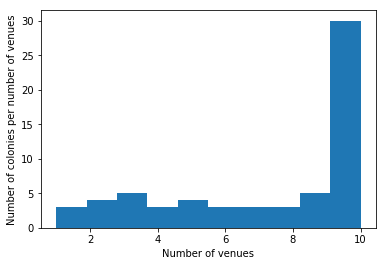

In [19]:
# number_venues_per_colony_df[["Venue"]].plot(kind="hist")

plt.hist(number_venues_per_colony_df["Venue"])

plt.xlabel("Number of venues")
plt.ylabel("Number of colonies per number of venues")

Showing the colonies with (at least) 10 points of interest

In [20]:
number_venues_per_colony_df[number_venues_per_colony_df["Venue"] >= 10]

,Venue
Colony,
ALGARIN,10
BUENOS AIRES,10
CENTRO III,10
CENTRO IV,10
CENTRO V,10
CENTRO VI,10
CENTRO VII,10
CENTRO VIII,10
CONDESA,10


Creating a map of Mexico City, showing Cuauhtemoc's venus

In [21]:
cuauhtemoc_venues_map = folium.Map(location=[cdmx_latitude, cdmx_longitude], zoom_start=14)

cvm_cuauhtemoc_colonies_srs = cuauhtemoc_colonies_df["Colony"]

cvm_colors_array = cm.hsv(np.linspace(0, 1, len(cvm_cuauhtemoc_colonies_srs)))
cvm_circle_marker_colors = [colors.rgb2hex(i) for i in cvm_colors_array]

for n_colony, n_venue, n_latitude, n_longitude in zip(cuauhtemoc_venues_df["Colony"], cuauhtemoc_venues_df["Venue"], cuauhtemoc_venues_df["Venue Latitude"], cuauhtemoc_venues_df["Venue Longitude"]):
    n_label = folium.Popup("{}, {}".format(n_colony, n_venue), parse_html=True)
    folium.CircleMarker(
        [n_latitude, n_longitude],
        radius=5,
        popup=n_label,
        color=cvm_circle_marker_colors[cvm_cuauhtemoc_colonies_srs[cvm_cuauhtemoc_colonies_srs == n_colony].index[0]],
        fill=True,
        fill_color=cvm_circle_marker_colors[cvm_cuauhtemoc_colonies_srs[cvm_cuauhtemoc_colonies_srs == n_colony].index[0]],
        fill_opacity=0.7,
        parse_html=True
    ).add_to(cuauhtemoc_venues_map)

cuauhtemoc_venues_map

![alt text](https://raw.githubusercontent.com/iSaaC92G/Crime-Analysis-of-Mexico-City/master/images/outputs/top_ten_venues_per_colonies.jpg "Top Ten Venues per Colonies")

Retrieving Cuauhtemoc's 2018 crime data set as a DataFrame

In [22]:
body = client_c00e74e766a148bf886ec060f0b9c13a.get_object(Bucket='fashionproject-donotdelete-pr-mv2ccdtjv6sbh4',Key='carpetas_de_investigacion_pgj_cdmx_cuauhtemoc_2018.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

cuauhtemoc_raw_crime_df = pd.read_csv(body, sep=";")

In [23]:
print("cuauhtemoc_raw_crime_df.dtypes:")
print(cuauhtemoc_raw_crime_df.dtypes)

print("cuauhtemoc_raw_crime_df.shape:", cuauhtemoc_raw_crime_df.shape)

cuauhtemoc_raw_crime_df.head()

cuauhtemoc_raw_crime_df.dtypes:
año_hechos                int64
mes_hechos               object
fecha_hechos             object
delito                   object
categoria_delito         object
fiscalía                 object
agencia                  object
unidad_investigacion     object
colonia_hechos           object
alcaldia_hechos          object
fecha_inicio             object
mes_inicio               object
ao_inicio                 int64
calle_hechos             object
calle_hechos2            object
longitud                float64
latitud                 float64
Geopoint                 object
dtype: object
cuauhtemoc_raw_crime_df.shape: (39431, 18)


,año_hechos,mes_hechos,fecha_hechos,delito,categoria_delito,fiscalía,agencia,unidad_investigacion,colonia_hechos,alcaldia_hechos,fecha_inicio,mes_inicio,ao_inicio,calle_hechos,calle_hechos2,longitud,latitud,Geopoint
0,2018,Abril,2018-04-22 12:00:00,FRAUDE,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN CUAUHTEMOC,CUH-5,UI-3SD,BUENAVISTA,CUAUHTEMOC,2019-03-28 20:16:48,Marzo,2019,BUENAVISTA,NaN,-99.149766,19.445845,"19.4458446955,-99.1497664001"
1,2018,Noviembre,2018-11-01 09:00:00,FRAUDE,DELITO DE BAJO IMPACTO,JUZGADOS CIVILES,74,UI-4SD,DOCTORES,CUAUHTEMOC,2019-06-21 14:50:38,Junio,2019,NIÑOS HEROES,NaN,-99.150205,19.420826,"19.4208262039,-99.1502050997"
2,2018,Marzo,2018-03-05 20:30:00,ROBO A PASAJERO A BORDO DE TRANSPORTE PÚBLICO ...,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN CUAUHTEMOC,CUH-4,UI-3SD,CENTRO,CUAUHTEMOC,2018-03-09 11:20:22,Marzo,2018,COMONFORT,REPUBLICA DE HONDURAS,-99.135343,19.440776,"19.4407757658,-99.1353429932"
3,2018,Marzo,2018-03-18 02:45:00,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,INVESTIGACIÓN EN CUAUHTEMOC,CUH-2,UI-2CD,BUENOS AIRES,CUAUHTEMOC,2018-03-18 04:22:17,Marzo,2018,RENACIMIENO,VIADUCTO MIGUEL ALEMAN,-99.147951,19.404274,"19.404273944,-99.147951151"
4,2018,Marzo,2018-03-18 03:54:00,DAÑO EN PROPIEDAD AJENA INTENCIONAL A AUTOMOVIL,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN CUAUHTEMOC,CUH-7,UI-2SD,ROMA NORTE,CUAUHTEMOC,2018-03-18 06:01:30,Marzo,2018,PUEBLA,AV. INSURGENTES SUR,-99.163750,19.422247,"19.4222468956,-99.1637496769"


Displaying summary statistics for cuauhtemoc_raw_crime_df

In [24]:
cuauhtemoc_raw_crime_df.describe(include="all")

,año_hechos,mes_hechos,fecha_hechos,delito,categoria_delito,fiscalía,agencia,unidad_investigacion,colonia_hechos,alcaldia_hechos,fecha_inicio,mes_inicio,ao_inicio,calle_hechos,calle_hechos2,longitud,latitud,Geopoint
count,39431.0,39431,39431,39431,39431,39431,39431,39431,38235,39431,39431,39431,39431.000000,39285,14862,38265.000000,38265.000000,38265
unique,NaN,12,24467,197,15,32,116,65,34,1,39395,12,NaN,7891,4151,NaN,NaN,26542
top,NaN,Octubre,2018-03-01 12:00:00,ROBO A TRANSEUNTE DE CELULAR SIN VIOLENCIA,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN CUAUHTEMOC,CUH-2,UI-1SD,CENTRO,CUAUHTEMOC,2018-09-09 15:47:09,Octubre,NaN,EJE CENTRAL LAZARO CARDENAS,EJE CENTRAL LAZARO CARDENAS,NaN,NaN,"19.4091109998,-99.1355209"
freq,NaN,3636,32,2982,32467,29364,9633,9465,8772,39431,2,3773,NaN,650,263,NaN,NaN,76
mean,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.053613,NaN,NaN,-99.148184,19.430434,NaN
std,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.225255,NaN,NaN,0.013304,0.014663,NaN
min,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,NaN,NaN,-99.184075,19.400067,NaN
25%,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,NaN,NaN,-99.158146,19.419209,NaN
50%,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,NaN,NaN,-99.147554,19.429945,NaN
75%,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,NaN,NaN,-99.137325,19.441626,NaN


Counting missing data per column of interest

In [25]:
crime_missing_data_df = cuauhtemoc_raw_crime_df.isna()

print("delito:")
print(crime_missing_data_df["delito"].value_counts())

print("categoria_delito:")
print(crime_missing_data_df["categoria_delito"].value_counts())

print("colonia_hechos:")
print(crime_missing_data_df["colonia_hechos"].value_counts())

delito:
False    39431
Name: delito, dtype: int64
categoria_delito:
False    39431
Name: categoria_delito, dtype: int64
colonia_hechos:
False    38235
True      1196
Name: colonia_hechos, dtype: int64


Showing the rows with colony missing data

In [26]:
cuauhtemoc_raw_crime_df[crime_missing_data_df["colonia_hechos"]].head()

,año_hechos,mes_hechos,fecha_hechos,delito,categoria_delito,fiscalía,agencia,unidad_investigacion,colonia_hechos,alcaldia_hechos,fecha_inicio,mes_inicio,ao_inicio,calle_hechos,calle_hechos2,longitud,latitud,Geopoint
37,2018,Marzo,2018-03-13 12:00:00,FALSIFICACION DE TITULOS AL PORTADOR Y DOCUMEN...,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN CUAUHTEMOC,CUH-5,UI-2SD,NaN,CUAUHTEMOC,2018-03-14 16:21:51,Marzo,2018,SE IGNORA LUGAR DE HECHOS,NaN,NaN,NaN,NaN
42,2018,Mayo,2018-05-15 09:00:00,ROBO A TRANSEUNTE DE CELULAR SIN VIOLENCIA,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN AGENCIAS DE ATENCIÓN ESPECIAL...,STCMH,UI-1CD,NaN,CUAUHTEMOC,2018-05-15 11:38:17,Mayo,2018,NaN,NaN,NaN,NaN,NaN
99,2018,Mayo,2018-05-07 23:00:00,ACOSO SEXUAL,DELITO DE BAJO IMPACTO,INVESTIGACIÓN PARA LA ATENCIÓN DE DELITOS SEXU...,FDS-6,FDS-6-03,NaN,CUAUHTEMOC,2018-05-17 14:46:55,Mayo,2018,SIN CALLES DEL SAP,NaN,NaN,NaN,NaN
106,2018,Diciembre,2018-12-02 09:00:00,ABUSO SEXUAL,DELITO DE BAJO IMPACTO,INVESTIGACIÓN PARA LA ATENCIÓN DE DELITOS SEXU...,FDS-6,FDS-6-02,NaN,CUAUHTEMOC,2019-02-22 16:15:00,Febrero,2019,DESCONOCIDO,NaN,NaN,NaN,NaN
117,2018,Octubre,2018-10-23 09:00:00,LA ADMINISTRACION DE JUSTICIA,DELITO DE BAJO IMPACTO,INVESTIGACIÓN DE LOS DELITOS COMETIDOS POR SER...,B,UI-3CD,NaN,CUAUHTEMOC,2018-12-01 15:27:09,Diciembre,2018,"JUZGGADO 23 DE LO FAMILIAR,",NO SCINCE,NaN,NaN,NaN


Cleaning and shaping cuauhtemoc_raw_crime_df

In [27]:
# Removing columns of no interest
cuauhtemoc_clean_crime_df = cuauhtemoc_raw_crime_df.drop(["año_hechos", "mes_hechos", "fiscalía", "agencia", "unidad_investigacion", "alcaldia_hechos", "fecha_inicio", "mes_inicio", "ao_inicio", "calle_hechos", "calle_hechos2", "Geopoint"], axis=1)

# Creating a dictionary of translations from spanish to english for the column labels
crimes_column_labels_translations_es_en_dict = {
    "fecha_hechos": "Crime Date",
    "delito": "Crime",
    "categoria_delito": "Crime Category",
    "colonia_hechos": "Crime Colony",
    "longitud": "Crime Longitude",
    "latitud": "Crime Latitude"
}

# Translating columns
cuauhtemoc_clean_crime_df = cuauhtemoc_clean_crime_df.rename(columns=crimes_column_labels_translations_es_en_dict)

# Removing the rows with missing colony
cuauhtemoc_clean_crime_df = cuauhtemoc_clean_crime_df[crime_missing_data_df["colonia_hechos"] == False]

print("cuauhtemoc_clean_crime_df.dtypes:")
print(cuauhtemoc_clean_crime_df.dtypes)

print("cuauhtemoc_clean_crime_df.shape:")
print(cuauhtemoc_clean_crime_df.shape)

cuauhtemoc_clean_crime_df.head()

cuauhtemoc_clean_crime_df.dtypes:
Crime Date          object
Crime               object
Crime Category      object
Crime Colony        object
Crime Longitude    float64
Crime Latitude     float64
dtype: object
cuauhtemoc_clean_crime_df.shape:
(38235, 6)


,Crime Date,Crime,Crime Category,Crime Colony,Crime Longitude,Crime Latitude
0,2018-04-22 12:00:00,FRAUDE,DELITO DE BAJO IMPACTO,BUENAVISTA,-99.149766,19.445845
1,2018-11-01 09:00:00,FRAUDE,DELITO DE BAJO IMPACTO,DOCTORES,-99.150205,19.420826
2,2018-03-05 20:30:00,ROBO A PASAJERO A BORDO DE TRANSPORTE PÚBLICO ...,DELITO DE BAJO IMPACTO,CENTRO,-99.135343,19.440776
3,2018-03-18 02:45:00,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,BUENOS AIRES,-99.147951,19.404274
4,2018-03-18 03:54:00,DAÑO EN PROPIEDAD AJENA INTENCIONAL A AUTOMOVIL,DELITO DE BAJO IMPACTO,ROMA NORTE,-99.163750,19.422247


Counting the number of unique Crime categories, Crimes and Crime colonies

In [28]:
cuauhtemoc_crime_columns_df = cuauhtemoc_clean_crime_df[["Crime Category", "Crime", "Crime Colony"]]

print("Number of unique Crime categories:", cuauhtemoc_crime_columns_df["Crime Category"].nunique())
print(cuauhtemoc_crime_columns_df[["Crime Category", "Crime"]].groupby("Crime Category").count())

# print("pd.unique(cuauhtemoc_crime_columns_df[\"Crime Category\"]):")
# print(pd.unique(cuauhtemoc_crime_columns_df["Crime Category"]))

print("Number of unique Crimes:", cuauhtemoc_crime_columns_df["Crime"].nunique())
print(cuauhtemoc_crime_columns_df[["Crime", "Crime Colony"]].groupby("Crime").count())

print("Number of unique Crime colonies:", cuauhtemoc_crime_columns_df["Crime Colony"].nunique())
print(cuauhtemoc_crime_columns_df[["Crime", "Crime Colony"]].groupby("Crime Colony").count())

Number of unique Crime categories: 15
                                                    Crime
Crime Category                                           
DELITO DE BAJO IMPACTO                              31687
HECHO NO DELICTIVO                                   1967
HOMICIDIO DOLOSO                                      121
LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO          97
ROBO A CASA HABITACIÓN CON VIOLENCIA                   36
ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON V...     39
ROBO A NEGOCIO CON VIOLENCIA                          414
ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN V...     17
ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA          45
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIO...    556
ROBO A REPARTIDOR CON Y SIN VIOLENCIA                 197
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOL...   2381
ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA                2
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                  582
VIOLACIÓN                         

Removing unwanted data

In [29]:
# These categories are not consider a threat to tourists
cuauhtemoc_crime_df = cuauhtemoc_clean_crime_df[cuauhtemoc_clean_crime_df["Crime Category"] != "HECHO NO DELICTIVO"]
cuauhtemoc_crime_df = cuauhtemoc_crime_df[cuauhtemoc_crime_df["Crime Category"] != "ROBO A REPARTIDOR CON Y SIN VIOLENCIA"]
cuauhtemoc_crime_df = cuauhtemoc_crime_df[cuauhtemoc_crime_df["Crime Category"] != "ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA"]

print("Number of unique Crime categories:", cuauhtemoc_crime_df["Crime Category"].nunique())
print(cuauhtemoc_crime_df[["Crime Category", "Crime"]].groupby("Crime Category").count())

print("Number of unique Crimes:", cuauhtemoc_crime_df["Crime"].nunique())
print(cuauhtemoc_crime_df[["Crime Category", "Crime"]].groupby("Crime").count())

print("Number of unique Crime colonies:", cuauhtemoc_crime_df["Crime Colony"].nunique())
print(cuauhtemoc_crime_df[["Crime Colony", "Crime Category"]].groupby("Crime Colony").count())

print("cuauhtemoc_crime_df.shape:")
print(cuauhtemoc_crime_df.shape)

cuauhtemoc_crime_df.head()

Number of unique Crime categories: 12
                                                    Crime
Crime Category                                           
DELITO DE BAJO IMPACTO                              31687
HOMICIDIO DOLOSO                                      121
LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO          97
ROBO A CASA HABITACIÓN CON VIOLENCIA                   36
ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON V...     39
ROBO A NEGOCIO CON VIOLENCIA                          414
ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN V...     17
ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA          45
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIO...    556
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOL...   2381
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                  582
VIOLACIÓN                                              94
Number of unique Crimes: 171
                                                    Crime Category
Crime                                                 

,Crime Date,Crime,Crime Category,Crime Colony,Crime Longitude,Crime Latitude
0,2018-04-22 12:00:00,FRAUDE,DELITO DE BAJO IMPACTO,BUENAVISTA,-99.149766,19.445845
1,2018-11-01 09:00:00,FRAUDE,DELITO DE BAJO IMPACTO,DOCTORES,-99.150205,19.420826
2,2018-03-05 20:30:00,ROBO A PASAJERO A BORDO DE TRANSPORTE PÚBLICO ...,DELITO DE BAJO IMPACTO,CENTRO,-99.135343,19.440776
3,2018-03-18 02:45:00,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,BUENOS AIRES,-99.147951,19.404274
4,2018-03-18 03:54:00,DAÑO EN PROPIEDAD AJENA INTENCIONAL A AUTOMOVIL,DELITO DE BAJO IMPACTO,ROMA NORTE,-99.163750,19.422247


Transforming the cuauhtemoc_crime_df DataFrame to set Crime categories as columns

In [30]:
cuauhtemoc_crime_categories_df = pd.get_dummies(cuauhtemoc_crime_df[["Crime Category"]], prefix="", prefix_sep="")

cuauhtemoc_crime_categories_df.insert(0, "Crime Colony", cuauhtemoc_crime_df["Crime Colony"])

print("cuauhtemoc_crime_categories_df.shape:")
print(cuauhtemoc_crime_categories_df.shape)

cuauhtemoc_crime_categories_df.head()

cuauhtemoc_crime_categories_df.shape:
(36069, 13)


,Crime Colony,DELITO DE BAJO IMPACTO,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACIÓN CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,VIOLACIÓN
0,BUENAVISTA,1,0,0,0,0,0,0,0,0,0,0,0
1,DOCTORES,1,0,0,0,0,0,0,0,0,0,0,0
2,CENTRO,1,0,0,0,0,0,0,0,0,0,0,0
3,BUENOS AIRES,0,0,0,0,0,0,0,0,0,1,0,0
4,ROMA NORTE,1,0,0,0,0,0,0,0,0,0,0,0


Grouping rows by Crime Colony and calculating the mean for each Crime category

In [31]:
cuauhtemoc_crime_grouped_by_colony_df = cuauhtemoc_crime_categories_df.groupby("Crime Colony").mean().reset_index()

print("cuauhtemoc_crime_grouped_by_colony_df.shape:")
print(cuauhtemoc_crime_grouped_by_colony_df.shape)

cuauhtemoc_crime_grouped_by_colony_df

cuauhtemoc_crime_grouped_by_colony_df.shape:
(34, 13)


,Crime Colony,DELITO DE BAJO IMPACTO,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACIÓN CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,VIOLACIÓN
0,ALGARIN,0.864035,0.000000,0.000000,0.000000,0.008772,0.048246,0.000000,0.000000,0.004386,0.052632,0.021930,0.000000
1,AMPLIACIÓN ASTURIAS,0.880478,0.000000,0.000000,0.000000,0.000000,0.023904,0.000000,0.003984,0.011952,0.043825,0.031873,0.003984
2,ASTURIAS,0.875862,0.006897,0.006897,0.000000,0.000000,0.006897,0.000000,0.000000,0.013793,0.034483,0.055172,0.000000
3,ATLAMPA,0.841530,0.016393,0.005464,0.000000,0.005464,0.008197,0.013661,0.002732,0.000000,0.057377,0.043716,0.005464
4,BUENAVISTA,0.903289,0.001964,0.000491,0.000491,0.000982,0.004418,0.000491,0.000000,0.009327,0.064801,0.010800,0.002946
5,BUENOS AIRES,0.855670,0.015464,0.005155,0.000000,0.005155,0.005155,0.000000,0.010309,0.000000,0.082474,0.005155,0.015464
6,CENTRO,0.833996,0.002893,0.002411,0.000362,0.000362,0.011212,0.000362,0.001326,0.031947,0.108861,0.004340,0.001929
7,CENTRO URBANO BENITO JUÁREZ,0.835616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013699,0.136986,0.013699,0.000000
8,CONDESA,0.902490,0.002075,0.000000,0.002075,0.002075,0.012448,0.000000,0.002075,0.000000,0.049793,0.024896,0.002075
9,CUAUHTÉMOC,0.926829,0.002033,0.000000,0.003049,0.003049,0.010163,0.000000,0.000000,0.001016,0.035569,0.016260,0.002033


Fitting the KMeans model

In [32]:
k_clusters = 7

cuauhtemoc_crime_grouped_to_cluster_df = cuauhtemoc_crime_grouped_by_colony_df.drop("Crime Colony", 1)

kmeans_model = KMeans(n_clusters=k_clusters, random_state=0).fit(cuauhtemoc_crime_grouped_to_cluster_df)

kmeans_model.labels_

array([5, 0, 0, 5, 3, 5, 1, 1, 0, 4, 4, 3, 4, 3, 6, 4, 0, 3, 4, 5, 0, 5,
       3, 0, 3, 0, 4, 4, 0, 0, 6, 0, 4, 2], dtype=int32)

Creating a dictionary of labeled colonies

In [33]:
cuauhtemoc_labeled_venues_df = pd.DataFrame(data={"Colony": cuauhtemoc_crime_grouped_by_colony_df["Crime Colony"], "Cluster Label": kmeans_model.labels_})

cuauhtemoc_labeled_venues_df["Colony"] = cuauhtemoc_labeled_venues_df["Colony"].apply(lambda x: x.replace("AMPLIACIÓN ASTURIAS", "ASTURIAS (AMPL)"))
cuauhtemoc_labeled_venues_df["Colony"] = cuauhtemoc_labeled_venues_df["Colony"].apply(lambda x: x.replace("CUAUHTÉMOC", "CUAUHTEMOC"))
cuauhtemoc_labeled_venues_df["Colony"] = cuauhtemoc_labeled_venues_df["Colony"].apply(lambda x: x.replace("EX-HIPÓDROMO DE PERALVILLO", "EX HIPODROMO DE PERALVILLO"))
cuauhtemoc_labeled_venues_df["Colony"] = cuauhtemoc_labeled_venues_df["Colony"].apply(lambda x: x.replace("HIPÓDROMO", "HIPODROMO"))
cuauhtemoc_labeled_venues_df["Colony"] = cuauhtemoc_labeled_venues_df["Colony"].apply(lambda x: x.replace("HIPÓDROMO CONDESA", "HIPODROMO CONDESA"))
cuauhtemoc_labeled_venues_df["Colony"] = cuauhtemoc_labeled_venues_df["Colony"].apply(lambda x: x.replace("JUÁREZ", "JUAREZ"))
cuauhtemoc_labeled_venues_df["Colony"] = cuauhtemoc_labeled_venues_df["Colony"].apply(lambda x: x.replace("NONOALCO TLATELOLCO", "NONOALCO-TLATELOLCO"))
cuauhtemoc_labeled_venues_df["Colony"] = cuauhtemoc_labeled_venues_df["Colony"].apply(lambda x: x.replace("SAN SIMÓN TOLNAHUAC", "SAN SIMON TOLNAHUAC"))
cuauhtemoc_labeled_venues_df["Colony"] = cuauhtemoc_labeled_venues_df["Colony"].apply(lambda x: x.replace("VALLE GÓMEZ", "VALLE GOMEZ"))

cuauhtemoc_labeled_venues_dict = cuauhtemoc_labeled_venues_df.to_dict("split")

cuauhtemoc_labeled_venues_dict = {d[0]:d[1] for d in cuauhtemoc_labeled_venues_dict["data"]}

cuauhtemoc_labeled_venues_dict

{'ALGARIN': 5,
 'ASTURIAS (AMPL)': 0,
 'ASTURIAS': 0,
 'ATLAMPA': 5,
 'BUENAVISTA': 3,
 'BUENOS AIRES': 5,
 'CENTRO': 1,
 'CENTRO URBANO BENITO JUAREZ': 1,
 'CONDESA': 0,
 'CUAUHTEMOC': 4,
 'DOCTORES': 4,
 'ESPERANZA': 3,
 'EX HIPODROMO DE PERALVILLO': 4,
 'FELIPE PESCADOR': 3,
 'GUERRERO': 6,
 'HIPODROMO': 4,
 'HIPODROMO CONDESA': 0,
 'JUAREZ': 3,
 'MAZA': 4,
 'MORELOS': 5,
 'NONOALCO-TLATELOLCO': 0,
 'OBRERA': 5,
 'PAULINO NAVARRO': 3,
 'PERALVILLO': 0,
 'ROMA NORTE': 3,
 'ROMA SUR': 0,
 'SAN RAFAEL': 4,
 'SAN SIMON TOLNAHUAC': 4,
 'SANTA MARIA INSURGENTES': 0,
 'SANTA MARIA LA RIBERA': 0,
 'TABACALERA': 6,
 'TRANSITO': 0,
 'VALLE GOMEZ': 4,
 'VISTA ALEGRE': 2}

Adding the KMeans labels to the Cuauhtemoc venues dataframe

In [34]:
cuauhtemoc_venues_labeled_colonies_df = cuauhtemoc_venues_df

def get_cluster_label(colony):
    for key, value in cuauhtemoc_labeled_venues_dict.items():
        if colony.startswith(key):
            return value

cuauhtemoc_venues_labeled_colonies_df["Cluster Label"] = cuauhtemoc_venues_labeled_colonies_df["Colony"].apply(lambda x: get_cluster_label(x))

# cuauhtemoc_venues_labeled_colonies_df[cuauhtemoc_venues_labeled_colonies_df.isnull().any(axis=1)]

cuauhtemoc_venues_labeled_colonies_df = cuauhtemoc_venues_labeled_colonies_df.dropna()

cuauhtemoc_venues_labeled_colonies_df["Cluster Label"] = cuauhtemoc_venues_labeled_colonies_df["Cluster Label"].astype("int64")

print("cuauhtemoc_venues_labeled_colonies_df.shape:")
print(cuauhtemoc_venues_labeled_colonies_df.shape)

cuauhtemoc_venues_labeled_colonies_df

cuauhtemoc_venues_labeled_colonies_df.shape:
(464, 8)


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Colony,Colony Latitude,Colony Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Label
0,GUERRERO IV,19.440422,-99.142214,Palacio De Bellas Artes,19.440565,-99.143499,Art Gallery,6
1,GUERRERO IV,19.440422,-99.142214,La Esquina Del Gourmet,19.439585,-99.143384,Taco Place,6
2,GUERRERO IV,19.440422,-99.142214,Escuela del Ballet Folklórico de México de Ama...,19.440168,-99.141200,College & University,6
3,GUERRERO IV,19.440422,-99.142214,Monumento a Simón Bolívar,19.440506,-99.143215,Sculpture Garden,6
4,NONOALCO-TLATELOLCO (U HAB) III,19.451696,-99.135357,Tulix Kaapeh,19.451010,-99.135925,Café,0
5,NONOALCO-TLATELOLCO (U HAB) III,19.451696,-99.135357,Centro Cultural Escenico Ernesto Gomez Cruz,19.451041,-99.133698,Indie Theater,0
6,NONOALCO-TLATELOLCO (U HAB) III,19.451696,-99.135357,Museo de sitio Tecpan de las Tres Culturas,19.451105,-99.134841,Art Museum,0
7,DOCTORES II,19.419874,-99.150850,Merendero Biarritz,19.419540,-99.152221,Mexican Restaurant,4
8,DOCTORES II,19.419874,-99.150850,Porrúa Tribunales,19.421351,-99.150060,Bookstore,4
9,DOCTORES II,19.419874,-99.150850,Pollos sin Aloas,19.420570,-99.152059,Fried Chicken Joint,4


Creating a map of Mexito City showing Cuauhtemoc's clusterd colonies

In [35]:
cuauhtemoc_clusters_map = folium.Map(location=[cdmx_latitude, cdmx_longitude], zoom_start=14)

colors_array = cm.rainbow(np.linspace(0, 0.8, k_clusters))
circle_marker_colors = [colors.rgb2hex(i) for i in colors_array]

# print("circle_marker_colors:")
# print(circle_marker_colors)

for n_colony, n_venue, n_latitude, n_longitude, n_cluster_label in zip(cuauhtemoc_venues_labeled_colonies_df["Colony"], cuauhtemoc_venues_labeled_colonies_df["Venue"], cuauhtemoc_venues_labeled_colonies_df["Venue Latitude"], cuauhtemoc_venues_labeled_colonies_df["Venue Longitude"], cuauhtemoc_venues_labeled_colonies_df["Cluster Label"]):
    n_label = folium.Popup("Colony: {}, Venue: {}, Cluster: {}".format(n_colony, n_venue, n_cluster_label), parse_html=True)
    folium.CircleMarker(
        [n_latitude, n_longitude],
        radius=5,
        popup=n_label,
        color=circle_marker_colors[n_cluster_label],
        fill=True,
        fill_color=circle_marker_colors[n_cluster_label],
        fill_opacity=1,
        parse_html=True
    ).add_to(cuauhtemoc_clusters_map)

cuauhtemoc_clusters_map

![alt text](https://raw.githubusercontent.com/iSaaC92G/Crime-Analysis-of-Mexico-City/master/images/outputs/classified_top_ten_venues_per_colony.jpg "Classified Top Ten Venues per Colony")

Grouping crimes by clusters

In [36]:
cuauhtemoc_labeled_colonies_df = pd.DataFrame(data={"Colony": cuauhtemoc_crime_grouped_by_colony_df["Crime Colony"], "Cluster Label": kmeans_model.labels_})

cuauhtemoc_labeled_colonies_dict = cuauhtemoc_labeled_colonies_df.to_dict("split")

cuauhtemoc_labeled_colonies_dict = {d[0]:d[1] for d in cuauhtemoc_labeled_colonies_dict["data"]}

print(cuauhtemoc_labeled_colonies_dict)


cuauhtemoc_crime_labeled_colonies_df = cuauhtemoc_crime_df.copy()

def get_cluster_label(colony, colony_cluster_label_dict):
    for key, value in colony_cluster_label_dict.items():
        if colony.startswith(key):
            return value

cuauhtemoc_crime_labeled_colonies_df["Cluster Label"] = cuauhtemoc_crime_labeled_colonies_df["Crime Colony"].apply(lambda x: get_cluster_label(x, cuauhtemoc_labeled_colonies_dict))

# cuauhtemoc_crime_labeled_colonies_df[cuauhtemoc_crime_labeled_colonies_df.isnull().any(axis=1)]

cuauhtemoc_crime_labeled_colonies_df = cuauhtemoc_crime_labeled_colonies_df.dropna()

cuauhtemoc_crime_labeled_colonies_df["Cluster Label"] = cuauhtemoc_crime_labeled_colonies_df["Cluster Label"].astype("int64")

print("cuauhtemoc_crime_labeled_colonies_df.shape:")
print(cuauhtemoc_crime_labeled_colonies_df.shape)

cuauhtemoc_crime_labeled_colonies_df.head()

{'ALGARIN': 5, 'AMPLIACIÓN ASTURIAS': 0, 'ASTURIAS': 0, 'ATLAMPA': 5, 'BUENAVISTA': 3, 'BUENOS AIRES': 5, 'CENTRO': 1, 'CENTRO URBANO BENITO JUÁREZ': 1, 'CONDESA': 0, 'CUAUHTÉMOC': 4, 'DOCTORES': 4, 'ESPERANZA': 3, 'EX-HIPÓDROMO DE PERALVILLO': 4, 'FELIPE PESCADOR': 3, 'GUERRERO': 6, 'HIPÓDROMO': 4, 'HIPÓDROMO CONDESA': 0, 'JUÁREZ': 3, 'MAZA': 4, 'MORELOS': 5, 'NONOALCO TLATELOLCO': 0, 'OBRERA': 5, 'PAULINO NAVARRO': 3, 'PERALVILLO': 0, 'ROMA NORTE': 3, 'ROMA SUR': 0, 'SAN RAFAEL': 4, 'SAN SIMÓN TOLNAHUAC': 4, 'SANTA MARIA INSURGENTES': 0, 'SANTA MARIA LA RIBERA': 0, 'TABACALERA': 6, 'TRANSITO': 0, 'VALLE GÓMEZ': 4, 'VISTA ALEGRE': 2}
cuauhtemoc_crime_labeled_colonies_df.shape:
(36069, 7)


,Crime Date,Crime,Crime Category,Crime Colony,Crime Longitude,Crime Latitude,Cluster Label
0,2018-04-22 12:00:00,FRAUDE,DELITO DE BAJO IMPACTO,BUENAVISTA,-99.149766,19.445845,3
1,2018-11-01 09:00:00,FRAUDE,DELITO DE BAJO IMPACTO,DOCTORES,-99.150205,19.420826,4
2,2018-03-05 20:30:00,ROBO A PASAJERO A BORDO DE TRANSPORTE PÚBLICO ...,DELITO DE BAJO IMPACTO,CENTRO,-99.135343,19.440776,1
3,2018-03-18 02:45:00,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,BUENOS AIRES,-99.147951,19.404274,5
4,2018-03-18 03:54:00,DAÑO EN PROPIEDAD AJENA INTENCIONAL A AUTOMOVIL,DELITO DE BAJO IMPACTO,ROMA NORTE,-99.163750,19.422247,3


Counting the number of crimes by cluster

In [37]:
cuauhtemoc_crime_labeled_colonies_df[["Crime Colony", "Cluster Label"]].groupby("Cluster Label").count()

,Crime Colony
Cluster Label,
0,5790
1,8368
2,398
3,7215
4,7848
5,3462
6,2988


Cluster's colonies ordered by crime rates

In [38]:
cuauhtemoc_high_crime_rates_by_colony_df = cuauhtemoc_crime_labeled_colonies_df[np.logical_or(np.logical_or(cuauhtemoc_crime_labeled_colonies_df["Cluster Label"] == 1, cuauhtemoc_crime_labeled_colonies_df["Cluster Label"] == 3), cuauhtemoc_crime_labeled_colonies_df["Cluster Label"] == 4)]

cuauhtemoc_high_crime_rates_by_colony_df = cuauhtemoc_high_crime_rates_by_colony_df[["Crime Category", "Crime Colony"]]

cuauhtemoc_high_crime_rates_by_colony_df = cuauhtemoc_high_crime_rates_by_colony_df.groupby("Crime Colony").count().reset_index()

cuauhtemoc_high_crime_rates_by_colony_df.rename(columns={"Crime Category": "Number of Crimes by Colony"}, inplace=True)

cuauhtemoc_high_crime_rates_by_colony_df.sort_values(by=["Number of Crimes by Colony"], ascending=False, inplace=True)

cuauhtemoc_high_crime_rates_by_colony_df.reset_index(drop=True)

,Crime Colony,Number of Crimes by Colony
0,CENTRO,8295
1,DOCTORES,3898
2,ROMA NORTE,2927
3,BUENAVISTA,2037
4,JUÁREZ,1965
5,HIPÓDROMO,1019
6,CUAUHTÉMOC,984
7,SAN RAFAEL,734
8,EX-HIPÓDROMO DE PERALVILLO,366
9,SAN SIMÓN TOLNAHUAC,364


Showing the venues found in those clusters

In [39]:
clusters_with_high_crime_rates_df = cuauhtemoc_venues_labeled_colonies_df[np.logical_or(np.logical_or(cuauhtemoc_venues_labeled_colonies_df["Cluster Label"] == 1, cuauhtemoc_venues_labeled_colonies_df["Cluster Label"] == 3), cuauhtemoc_venues_labeled_colonies_df["Cluster Label"] == 4)].reset_index()

print("clusters_with_high_crime_rates_df.shape:", clusters_with_high_crime_rates_df.shape)

clusters_with_high_crime_rates_df["Venue"].to_list()

clusters_with_high_crime_rates_df.shape: (232, 9)


['Merendero Biarritz',
 'Porrúa Tribunales',
 'Pollos sin Aloas',
 'El Tapanco',
 'Receta Minima',
 'La Mezcalli',
 'La audiencia',
 'La Nueva Casa del Abogado',
 'Bodega Aurrera',
 'Tacos la gardenia',
 'TIANGUIS DE LA COL. DOCTORES.',
 'Tianguis Col. Buenos Aires',
 'Mini Bodega Aurrera',
 'Barbacoa El compadre',
 'Los Barriles',
 'Carnitas',
 'Tortas San Simon',
 'Salon El Dandy',
 'polaris GYM',
 'la casa de los helados',
 'El Sauce Y La Palma "qkas"',
 'Delicias Celene',
 'Centro Arista',
 'Deportivo Cuauhtémoc',
 'Yubá',
 'BP Gasolinera Aldama',
 'Walmart Buenavista',
 'Feria de Buenavista',
 'Panda Express',
 '61 Blues Jazz & Other Grooves',
 'Bonebreakers Dojo Central',
 "Arrachera's Grill",
 'Mecanico Jeans Centro',
 'Plaza Tlaxcoaque',
 "Domino's Pizza",
 'MÁSCARA DE LÁTEX 20 De Noviembre',
 'Fust ONE',
 'Pasta Di Roma',
 'BoneBreakers Central',
 'VegAmo',
 'Panqué de Nata Finnniiiisssimo Sabor!',
 'Café El Cordobés',
 'Ricos Tacos De Cochinita Pibil',
 'Oaxaca en México',
 '